In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

%matplotlib inline


In [2]:
def multiplot(images, figure_size = (12,9), cmap=None):
    plt.figure(figsize=figure_size)
    n_images = len(images)
    nrow = np.ceil(n_images/2)
    for i in range(n_images):
        plt.subplot(nrow, 2, i+1)
        plt.tight_layout()
        if cmap:
            plt.imshow(images[i], cmap=cmap)
        else:
            plt.imshow(images[i])

In [118]:
# define feature extraction functions
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def stack_region(image, window_img, w1, w2):
    result = cv2.addWeighted(image, w1, window_img, w2, 0)
    return result

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw=False):
    
    draw_img = np.copy(img)
    #draw_img = np.zeros_like(img)
    #img = img.astype(np.float32)/255
    
    ctrans_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        #imshape = ctrans_tosearch.shape
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # boxes
    detected = []
    count = 0
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print ('features in the process function: '+ str(len(test_features[0])))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ybox_top = np.int(ytop*scale)
                win_length = np.int(window*scale)
                box = ((xbox_left, ybox_top+ystart),(xbox_left+win_length,ybox_top+win_length+ystart))
                if draw == True:
                    cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)
                detected.append(box)
    print (str(len(detected))+' boxes found')
    print ('windows: ' + str(count))
    if draw == True:
        return draw_img, detected
    else:
        return detected

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img    


In [80]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [81]:
# Train model
# Extract training image 
# Images paths for cars
cars_GTI_Far = glob.glob('vehicles/GTI_Far/*.png')
cars_GTI_Left = glob.glob('vehicles/GTI_Left/*.png')
cars_GTI_MiddleClose = glob.glob('vehicles/GTI_MiddleClose/*.png')
cars_GTI_Right = glob.glob('vehicles/GTI_Right/*.png')
cars_KITTI_extracted = glob.glob('vehicles/KITTI_extracted/*.png')

# Image paths for non-cars
noncars_Extras = glob.glob('non-vehicles/Extras/*.png')
noncars_GTI = glob.glob('non-vehicles/Extras/*.png')

cars = np.hstack((cars_GTI_Far, cars_GTI_Left, cars_GTI_MiddleClose, cars_GTI_Right, cars_KITTI_extracted))
noncars = np.hstack((noncars_GTI, noncars_Extras))

print ('The number of samples for cars and noncars are:')
print ('cars: '+ str(len(cars)))
print ('noncars: '+ str(len(noncars)))


The number of samples for cars and noncars are:
cars: 8792
noncars: 10136


In [6]:
# Feature extraction
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True
y_start_stop = [400, 656]
scale = 1.5


In [7]:
car_features = []
for car in cars:
    img = cv2.cvtColor(cv2.imread(car), cv2.COLOR_BGR2RGB)
    feature = single_img_features(img, color_space=color_space, spatial_size = spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    car_features.append(feature)

In [8]:
noncar_features = []
for noncar in noncars:
    img = cv2.cvtColor(cv2.imread(noncar), cv2.COLOR_BGR2RGB)
    feature = single_img_features(img, color_space=color_space, spatial_size = spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    noncar_features.append(feature)

In [30]:
print ('Feature Number: ' + str(len(car_features[0])))

Feature Number: 6108


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)



In [10]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)



In [48]:
print(score)

0.998943475964


In [11]:
from sklearn.externals import joblib
joblib.dump(clf, 'models/svm_blank.pkl')

['models/svm_blank.pkl']

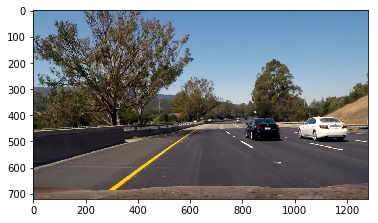

In [62]:
test=cv2.cvtColor(cv2.imread('test_images/test6.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(test)

In [113]:
import time

clf = joblib.load('models/svm_blank.pkl')

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True
y_start_stop = [400, 656]
scale = 1.5
scale_range = [1, 2]
scale_steps = 2
heat_thresh = 2

t = time.time()
detected = []
boxes = find_cars(test, y_start_stop[0], y_start_stop[1], 
                    scale, clf, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)
if len(boxes) != 0:
    detected.append(boxes)

if len(detected) >0:
    detected = np.concatenate(detected)

print ('run time is: '+ str(time.time() - t))
        


2 boxes found
windows: 294
run time is: 4.717836856842041


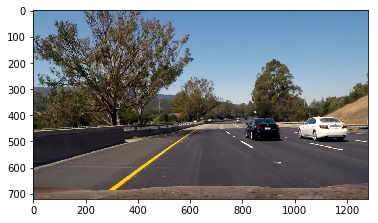

In [83]:
out_img = np.copy(test)
for box in detected:
    print(box)
    cv2.rectangle(out_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0,0,255), 6)

plt.imshow(out_img)


In [124]:
from scipy.ndimage.measurements import label

def process(img):
    clf = joblib.load('models/svm_blank.pkl')

    color_space = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (16,16)
    hist_bins = 16
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    y_start_stop = [400, 656]
    scale_range = [1, 2]
    scale_steps = 2
    heat_thresh = 1
    #for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
    t = time.time()
    detected = []
    boxes = find_cars(img, y_start_stop[0], y_start_stop[1], 
                        scale, clf, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins)
    if len(boxes) != 0:
        detected.append(boxes)

    if len(detected) >0:
        detected = np.concatenate(detected)
    
    img_shape = img.shape
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap, detected)
    heatmap = apply_threshold(heatmap, heat_thresh)
    
    labels = label(heatmap)
    outimg = draw_labeled_bboxes(np.copy(img), labels)
    print ('run time is: '+ str(time.time() - t))
    return outimg
    

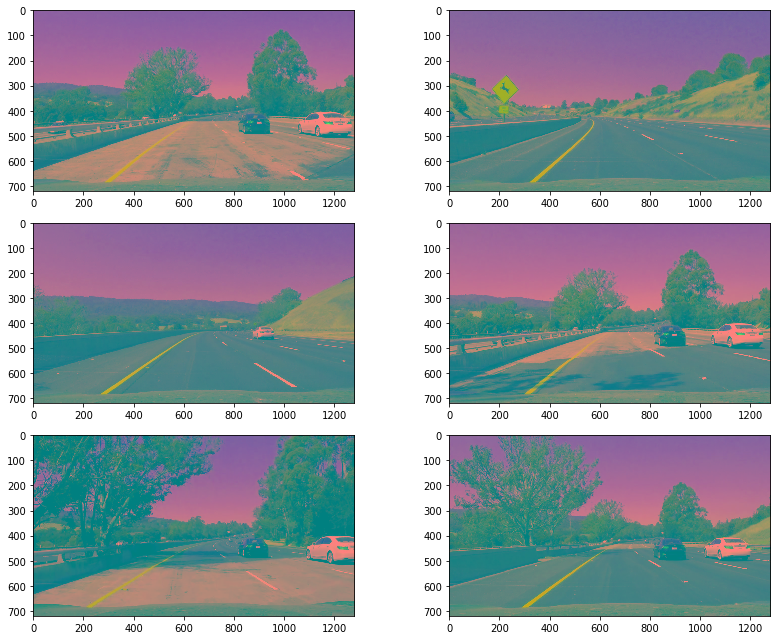

In [ ]:
test_images_paths = glob.glob('test_images/*.jpg')
test_images = []
for image_path in test_images_paths:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2YCrCb)
    test_images.append(image)

multiplot(test_images)


In [ ]:
output_images = []

for image in test_images:
    out_img = process(image)
    output_images.append(out_img)


3 boxes found
windows: 294
run time is: 4.944244861602783
0 boxes found
windows: 294
run time is: 4.224508047103882
1 boxes found
windows: 294
run time is: 3.9633090496063232
2 boxes found
windows: 294
run time is: 4.868844985961914
2 boxes found
windows: 294
run time is: 5.817306995391846


In [ ]:
multiplot(output_images)

In [139]:
from moviepy.editor import VideoFileClip
output_video = 'output.mp4'
input_video = 'project_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(process)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



  3%|▎         | 37/1261 [15:05<8:24:21, 24.72s/it]

KeyboardInterrupt: 

In [155]:
print(score)

0.998943475964
